# Train Random Forest Model

In this notebook, we train a random forest model using data collected so far.

## 1. Setup

Import libraries and download training data.

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import joblib

import training_data_helpers as td_helpers

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_df_raw = td_helpers.load_training_data()
training_df = td_helpers.prepare_training_data(training_df_raw)
training_df.head()

File 'training_data.parquet' downloaded successfully to 'training_data.parquet'


,date,snow_depth,red,green,blue,coastal,nir08,swir16,swir22,fsca,item_id,station_triplet,latitude,longitude,elevation,datetime,month
0,2025-05-10T18:49:15.298686Z,87,23783,24067,24563,24717.0,24915,16878,17017,539.0,LC08_CU_004002_20250510_20250518_02_SR,1085:WA:SNTL,46.86956,-121.53434,5260.0,2025-05-10 18:49:15.298686+00:00,5
1,2025-05-26T18:49:08.643245Z,64,30420,30484,31724,31765.0,30553,22723,18696,531.0,LC08_CU_004002_20250526_20250606_02_SR,1085:WA:SNTL,46.86956,-121.53434,5260.0,2025-05-26 18:49:08.643245+00:00,5
2,2025-04-24T18:49:03.983677Z,121,20230,20543,20727,19248.0,21290,8042,7762,742.0,LC08_CU_004002_20250424_20250503_02_SR,1085:WA:SNTL,46.86956,-121.53434,5260.0,2025-04-24 18:49:03.983677+00:00,4
3,2025-05-01T18:55:04.333565Z,109,20102,19735,20009,18958.0,20637,7832,7657,NaN,LC08_CU_004002_20250501_20250511_02_SR,1085:WA:SNTL,46.86956,-121.53434,5260.0,2025-05-01 18:55:04.333565+00:00,5
4,2025-05-18T18:49:11.983471Z,79,24109,23672,24416,23895.0,27251,12570,12144,NaN,LC09_CU_004002_20250518_20250721_02_SR,1085:WA:SNTL,46.86956,-121.53434,5260.0,2025-05-18 18:49:11.983471+00:00,5


## 2. Prepare data for training

Load input and output columns from data frame and scale data.

In [3]:
input_columns = ["red", "green", "blue", "coastal", "nir08", "swir16", "swir22", "fsca", "latitude", "longitude", "month"]
input_data = training_df[input_columns]
output_columns = ['snow_depth']
output_data = training_df[output_columns].values

X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(input_data).astype(np.float32)
Y_scaler = MinMaxScaler()
Y_scaled = Y_scaler.fit_transform(output_data).astype(np.float32)

## 3. Split data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y_scaled, test_size=0.33, random_state=42)

## 4. Train Random Forest model

In [5]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

/usr/local/lib64/python3.12/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 5. Evaluate the model

The Pearson Correlation Coefficient is 0.90. Being close to 1 indicates a strong positive relationship between the actual data and the predicted data.

In [6]:
random_forest_y_pred = rf_model.predict(X_test)
random_forest_pearsonr = pearsonr(random_forest_y_pred, y_test[:,0])
random_forest_pearsonr

PearsonRResult(statistic=np.float64(0.9206810277344875), pvalue=np.float64(0.0))

Text(0, 0.5, 'predicted snow depth')

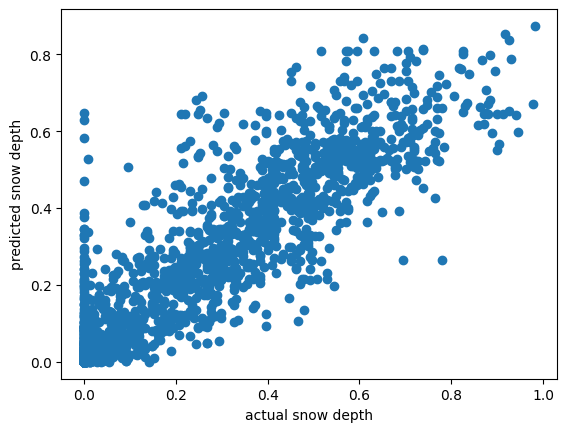

In [7]:
plt.scatter(y_test[:,0], random_forest_y_pred)
plt.xlabel("actual snow depth")
plt.ylabel("predicted snow depth")

Mean squared error is 0.011, an improvement over our linear model.

In [8]:
mean_squared_error(random_forest_y_pred, y_test)

0.008318645743270316

### Feature Importance

NOTE: Month has by far the greatest feature importance. The band data is adding less predictive power than month and even latitude and longitude.

In [9]:
list(zip(input_columns, rf_model.feature_importances_))

[('red', np.float64(0.008701702382263497)),
 ('green', np.float64(0.010310465462719512)),
 ('blue', np.float64(0.013305878678377993)),
 ('coastal', np.float64(0.015313590914898666)),
 ('nir08', np.float64(0.018418145266139118)),
 ('swir16', np.float64(0.022281502914400977)),
 ('swir22', np.float64(0.02101851359383843)),
 ('fsca', np.float64(0.033451751346727246)),
 ('latitude', np.float64(0.034481180261599007)),
 ('longitude', np.float64(0.3645520152724805)),
 ('month', np.float64(0.45816525390655516))]

## 7. Save the model

In [10]:
# Save individual models
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(X_scaler, 'X_scaler.pkl')
joblib.dump(Y_scaler, 'Y_scaler.pkl')

print("Models and scalers saved successfully!")

Models and scalers saved successfully!
